In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
from scipy.stats import norm
import math
from statsmodels.stats.power import tt_ind_solve_power

In [91]:
ALPHA = 0.05
POWER = 0.8
RANDOM_SEED = 42
sns.set(style='whitegrid', context='poster')
# color codes
healthy_orange = '#EC6602'
healthy_orange_25 = '#FDDDCB'
siemens_petrol = '#009999'
siemens_petrol_50 = '#87D2D2'

Link zum Datensatz: https://www.kaggle.com/datasets/fernandogarciah24/top-1000-imdb-dataset

In [92]:
df = pd.read_csv('data/movies_data.csv')

df.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,Subgenre,Subgenre 1,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Shawshank Redemption,1994,A,142,Drama,NaN,NaN,9.3,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,The Godfather,1972,A,175,Crime,Drama,NaN,9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,The Dark Knight,2008,UA,152,Action,Crime,Drama,9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,The Godfather: Part II,1974,A,202,Crime,Drama,NaN,9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,12 Angry Men,1957,U,96,Crime,Drama,NaN,9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


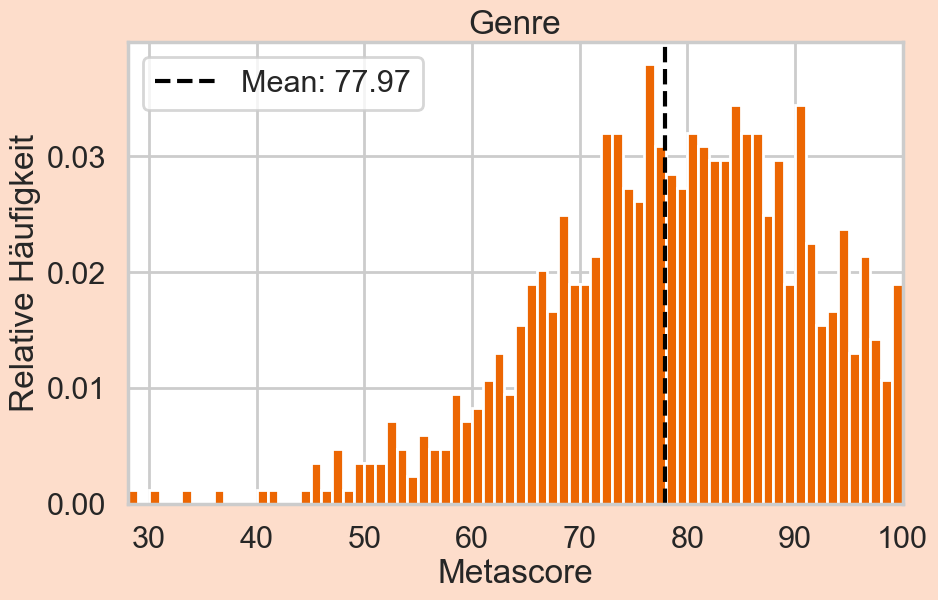

In [93]:
plt.figure(figsize=(10, 6), facecolor=healthy_orange_25)
plt.hist(df.Meta_score, 
         bins=range(int(df.Meta_score.min()), int(df.Meta_score.max()) + 1), 
         color=healthy_orange, 
         density=True)
genre_mean = df.Meta_score.mean()
plt.axvline(x=genre_mean, color='black', label=f'Mean: {genre_mean:.2f}', linestyle='--')
plt.xlabel('Metascore')
plt.ylabel('Relative Häufigkeit')
plt.title('Genre')
plt.legend()
plt.xlim(int(df.Meta_score.min()), 100)
plt.show()

In [94]:
df_pivoted_meta = df.pivot_table(index='Genre', 
                                 values='Meta_score', 
                                 aggfunc=['mean', 'count', 'median', 'std', 'min', 'max'])

df_pivoted_meta.sort_values(('mean', 'Meta_score'), ascending=False)

,mean,count,median,std,min,max
,Meta_score,Meta_score,Meta_score,Meta_score,Meta_score,Meta_score
Genre,,,,,,
Film-Noir,95.666667,3,96.0,1.527525,94.0,97.0
Animation,81.093333,75,82.0,8.813646,61.0,96.0
Thriller,81.000000,1,81.0,NaN,81.0,81.0
Horror,80.000000,11,87.0,15.362291,46.0,97.0
Drama,79.701245,241,82.0,12.744687,28.0,100.0
Mystery,79.125000,8,77.0,18.604435,52.0,100.0
Family,79.000000,2,79.0,16.970563,67.0,91.0
Comedy,78.720000,125,79.0,11.829160,45.0,99.0


### Einleitung

In der Welt des Kinos spielt die Bewertung von Filmen durch Kritiker eine wichtige Rolle bei dem Erfolg eines Films.

Eine der gewöhnlichen Methoden zur Bewertung ist Metascore. Der Meta-Score bietet eine schnelle Übersicht über die allgemeine Meinung zu dem Film.

Meta-Score wird von der Website Metacritic erstellt. Er fast die Kritiken aus verschiedenen Quellen zusammen und berechnet einen Durchschnittswert.

### Fragestellung

Haben Actionfilme im Durchschnitt schlechtere Bewerungen als Dramen?

In [95]:
df_filtered_action = df[df['Genre'] == 'Action']['Meta_score']
df_filtered_drama = df[df['Genre'] == 'Drama']['Meta_score']

In [96]:
df_filtered_action.isna().sum(), df_filtered_drama.isna().sum() 

(np.int64(29), np.int64(48))

In [97]:
df_filtered_action = df_filtered_action[~df_filtered_action.isna()].reset_index(drop=True)
df_filtered_drama = df_filtered_drama[~df_filtered_drama.isna()].reset_index(drop=True)


df_filtered_action.isna().sum(), df_filtered_drama.isna().sum()

(np.int64(0), np.int64(0))

In [98]:
df_filtered_action = df_filtered_action.astype('uint8')
df_filtered_drama = df_filtered_drama.astype('uint8')

df_filtered_action.dtype, df_filtered_drama.dtype

(dtype('uint8'), dtype('uint8'))

In [99]:
df_filtered_action[:10]

0    84
1    94
2    74
3    92
4    87
5    73
6    82
7    90
8    85
9    98
Name: Meta_score, dtype: uint8

In [100]:
df_filtered_drama[:10]

0    80
1    66
2    82
3    83
4    91
5    89
6    88
7    66
8    62
9    80
Name: Meta_score, dtype: uint8

In [101]:
min_action = df_filtered_action.min().item()
max_action = df_filtered_action.max().item()
mean_action = df_filtered_action.mean().item()
count_action = df_filtered_action.count().item()
std_action_emp = (df_filtered_action.std() * math.sqrt(count_action / (count_action - 1))).item()
min_drama = df_filtered_drama.min().item()
max_drama = df_filtered_action.max().item()
mean_drama = df_filtered_drama.mean().item()
count_drama = df_filtered_drama.count().item()
std_drama_emp = (df_filtered_drama.std() * math.sqrt(count_drama / (count_drama - 1))).item()

print(f"{min_action = }\n{max_action = }\n{mean_action = :.2f}\n{count_action = }")
print(f"Empirische Standardabweichung (Action) = {std_action_emp:.2f}")
print(f"{min_drama = }\n{max_drama = }\n{mean_drama = :.2f}\n{count_drama = }")
print(f"Empirische Standardabweichung (Drama) = {std_drama_emp:.2f}")

min_action = 33
max_action = 98
mean_action = 73.42
count_action = 143
Empirische Standardabweichung (Action) = 12.46
min_drama = 28
max_drama = 98
mean_drama = 79.70
count_drama = 241
Empirische Standardabweichung (Drama) = 12.77


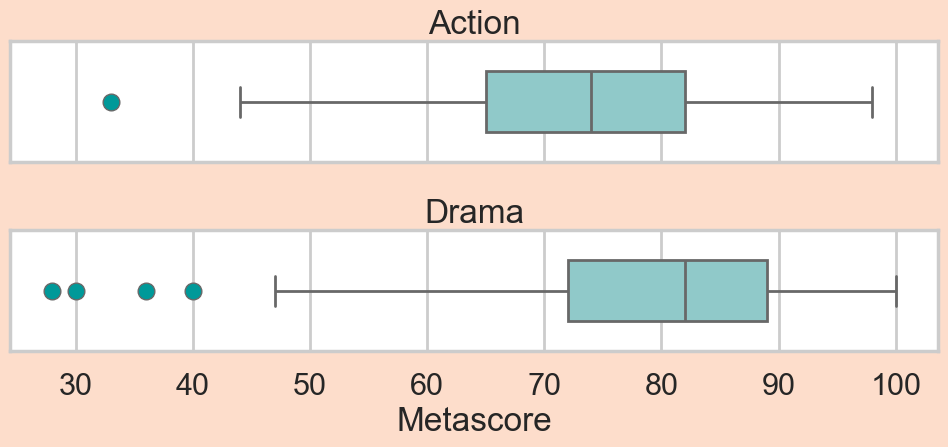

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, facecolor=healthy_orange_25)

sns.boxplot(df_filtered_action, 
            ax=ax[0], 
            color=siemens_petrol_50, 
            orient='y', 
            linewidth=2, 
            width=0.5,
            flierprops={'marker': 'o', 'markerfacecolor': siemens_petrol})
ax[0].set_title('Action')

sns.boxplot(df_filtered_drama, 
            ax=ax[1], 
            color=siemens_petrol_50, 
            orient='y', 
            linewidth=2, 
            width=0.5,
            flierprops={'marker': 'o', 'markerfacecolor': siemens_petrol})
ax[1].set_title('Drama')
plt.xlabel('Metascore')
plt.tight_layout()
plt.show()

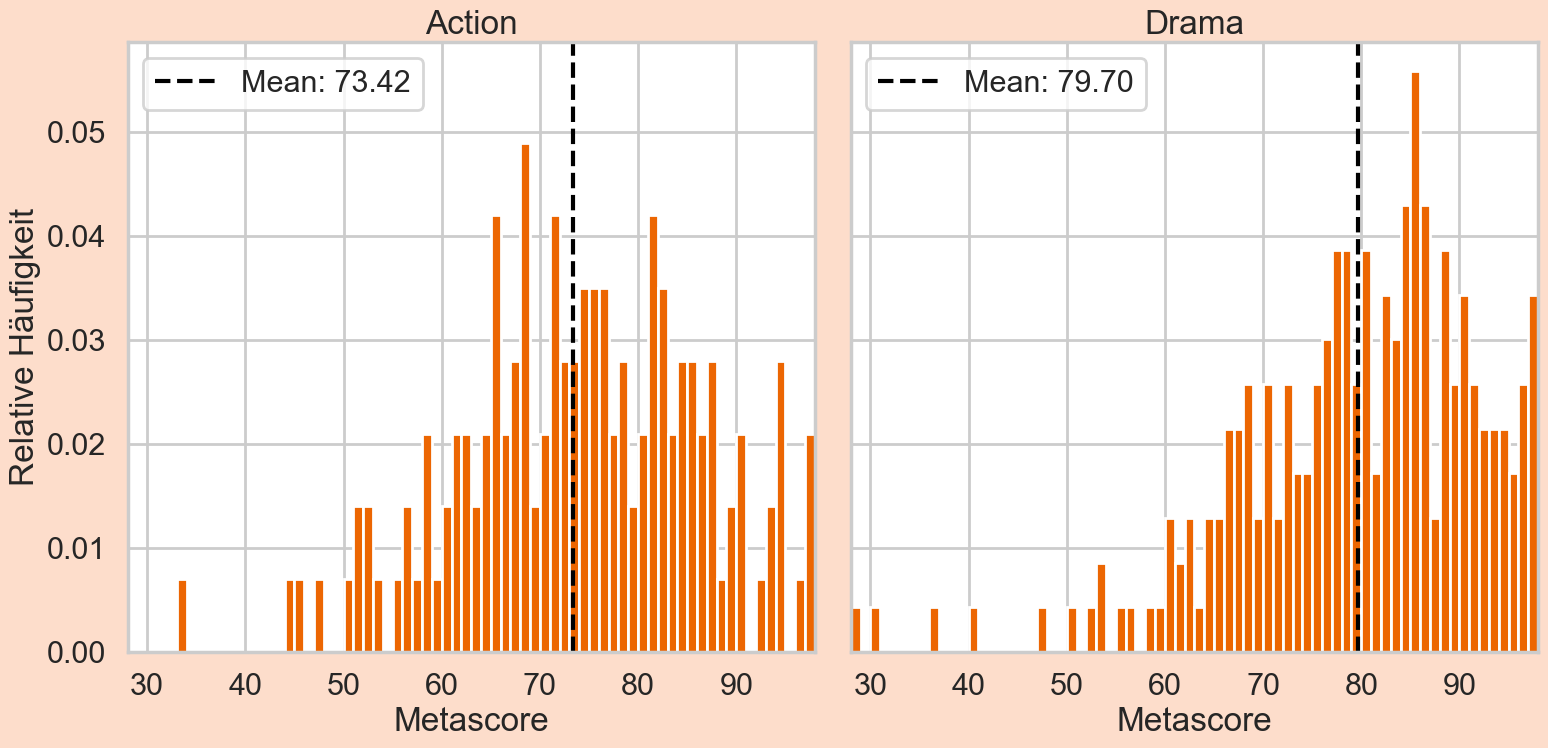

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True, facecolor=healthy_orange_25)

ax[0].hist(df_filtered_action, bins=range(min_action, max_action + 1), color=healthy_orange, density=True)
ax[0].axvline(x=mean_action, color='black', linestyle='--', label=f"Mean: {mean_action:.2f}")
ax[0].set_title('Action')
ax[0].set_xlabel('Metascore')
ax[0].set_ylabel('Relative Häufigkeit')
ax[0].set_xlim(min(min_action, min_drama), max(max_action, max_drama))
ax[0].legend()
ax[1].hist(df_filtered_drama, bins=range(min_drama, max_drama + 1), color=healthy_orange, density=True)
ax[1].axvline(x=mean_drama, color='black', linestyle='--', label=f"Mean: {mean_drama:.2f}")
ax[1].set_title('Drama')
ax[1].set_xlabel('Metascore')
ax[1].legend()
plt.tight_layout()
plt.show()

### Methode
#### 1- Voraussetzung:
Da die Grafiken zumindest eine annähernd normale Verteilung zeigen und die Stichprobengrößen größer als 30 sind, kann laut dem zentralen Grenzwertsatz eine Normalverteilung angenommen werden.

#### 2- Teststatistik:
Wir führen daher einen einseitigen t-Test für den Mittelwert von zwei unabhängigen Stichproben durch.

#### 3- Hypothesenformulierung:

$H_0$: Es gibt keinen signifikanten Unterschied zwischen den durchschnittlichen Metascores von Actionfilmen und Dramen.
$$\Rightarrow \mu_{Action} \geq \mu_{Drama}$$
$H_1$: Der durchschnittliche Metascore von Actionfilmen ist signifikant niedriger als der von Dramen.
$$\Rightarrow \mu_{Action} < \mu_{Drama}$$

#### 4- Kritischer Wert:

Da unsere Stichprobengröße größer als $30$ ist, können wir den berechneten t-Wert direkt mit dem z-Wert vergleichen. Für einen einseitigen Test mit einem Signifikanzniveau von 5% beträgt der kritische z-Wert $1.65$.

$$\Rightarrow Z_{krit} = 1.65$$ 

#### 5- Stichprobengröße Berechnen:
##### - Gepoolte Standardabweichung:
Da wir in unseren zwei Stichproben unterschiedliche, aber ähnliche Standardabweichungen haben, müssen wir diese zuerst zu einer sogenannten gepoolten Standardabweichung zusammenfassen. Dafür verwenden wir die folgende Formel:
$$ \hat{s}_{pooled} = \sqrt{\frac{(n_A - 1)\hat{s}_{A}^2 + (n_B - 1)\hat{s}_B^2}{n_A + n_B - 2}}$$

Dabei gilt,

- $n_A$ und $n_B$ sind die Stichprobengrößen von Stichprobe A und B

- $\hat{s}_A$ und $\hat{s}_B$ sind die *empirischen* Standardabweichungen der Stichprobe A und B

##### - Cohen's d:
Man berechnet Cohen's d mit der folgende Formel:
$$ d = \frac{\bar{X}_A - \bar{X}_B}{\hat{s}_{pooled}}$$

Dabei gilt,

- $\bar{X}_A$ und $\bar{X}_B$ sind die Mittelwerte von Stichprobe A und B

Hinweis: Cohen's d kann als effect-size in der Funktion 'tt_ind_solve_power()' verwendet werden.


In [104]:
gepoolte_std = math.sqrt(((count_action - 1)*math.pow(std_action_emp, 2) + 
                          (count_drama - 1)*math.pow(std_drama_emp, 2)) / 
                          (count_action + count_drama - 2))

cohens_d = (mean_action - mean_drama) / gepoolte_std

ratio = 1.0
n_action = round(tt_ind_solve_power(effect_size=cohens_d, 
                              alpha=ALPHA, 
                              power=POWER, 
                              ratio=ratio, 
                              alternative='smaller'))
n_drama = round(ratio * n_action)

print(f"Gepoolte Standardabweichung = {gepoolte_std:.2f}\nCohen's d = {cohens_d:.2f}")
print(f"Stichprobengröße (Action) = {n_action}\nStichprobengröße (Drama) = {n_drama}")

Gepoolte Standardabweichung = 12.66
Cohen's d = -0.50
Stichprobengröße (Action) = 51
Stichprobengröße (Drama) = 51


In [105]:
df_action_stichprobe = df_filtered_action.sample(n_action, random_state=RANDOM_SEED)
df_drama_stichprobe = df_filtered_drama.sample(n_drama, random_state=RANDOM_SEED)

In [106]:
t_wert, p_wert = ttest_ind(df_action_stichprobe, df_drama_stichprobe, equal_var=False)

print(f"t-Wert = {t_wert:.2f}\np-Wert = {p_wert*100:.2f}%")

if p_wert < ALPHA:
    print("Signifikantes Ergebnis")
else:
    print("NICHT signifikantes Ergebnis")

t-Wert = -2.46
p-Wert = 1.57%
Signifikantes Ergebnis


### Ergebnis:
Da,
$$\Rightarrow |t| > |Z_{krit}|$$
$\Rightarrow$ $H_0$ wird verworfen, $H_1$ wird angenommen.
$$\Rightarrow \mu_{Action} < \mu_{drama}$$

### Diskussion:
Dieser Unterschied kann durch diese Faktoren
verursacht werden:
- Viele Kritiker bevorzugen tiefgründigere Geschichten und anspruchsvollere Themen, die in Dramen häufiger vorkommen.
- Kritiker könnten Actionfilme als formelhaft oder uninspiriert empfinden, was zu niedrigeren Bewertungen führt.

### Fazit:
Wir können also mit 95%iger Sicherheit sagen,dass Actionfilme im Durchschnitt schlechtere Bewertungen erhalten als Dramen.

In [107]:
std_stichprobe_action_emp = df_action_stichprobe.std() * math.sqrt(n_action / (n_action - 1))
std_stichprobe_drama_emp = df_drama_stichprobe.std() * math.sqrt(n_drama / (n_drama - 1))
mean_stichprobe_action = df_action_stichprobe.mean()
mean_stichprobe_drama = df_drama_stichprobe.mean()
std_fehler_drama = std_stichprobe_drama_emp / n_drama**0.5
z_krit = norm.ppf(1 - ALPHA)
x_anfang = mean_stichprobe_drama - 5 * std_fehler_drama
x_ende = mean_stichprobe_drama + 5 * std_fehler_drama
untere_grenze = mean_stichprobe_drama - z_krit * std_fehler_drama
x_werte = np.linspace(x_anfang, x_ende, 1000)
y_werte = norm.pdf(x_werte, mean_stichprobe_drama, std_fehler_drama)

print(f"Empirische Standardabweichung von der Action Stichprobe = {std_stichprobe_action_emp:.2f}")
print(f"Empirische Standardabweichung von der Drama Stichprobe = {std_stichprobe_drama_emp:.2f}")
print(f"Mean von der Action Stichprobe = {mean_stichprobe_action:.2f}")
print(f"Mean von der Drama Sitchprobe = {mean_stichprobe_drama:.2f}")
print(f"Standard Fehler von der Drama Stichprobe = {std_fehler_drama:.2f}")
print(f"kritscher z-Wert = {z_krit:.2f}")
print(f"x-Anfang = {x_anfang:.2f}")
print(f"x-Ende = {x_ende:.2f}")
print(f"untere Grenze = {untere_grenze:.2f}")

Empirische Standardabweichung von der Action Stichprobe = 12.83
Empirische Standardabweichung von der Drama Stichprobe = 14.76
Mean von der Action Stichprobe = 72.78
Mean von der Drama Sitchprobe = 79.45
Standard Fehler von der Drama Stichprobe = 2.07
kritscher z-Wert = 1.64
x-Anfang = 69.12
x-Ende = 89.78
untere Grenze = 76.05


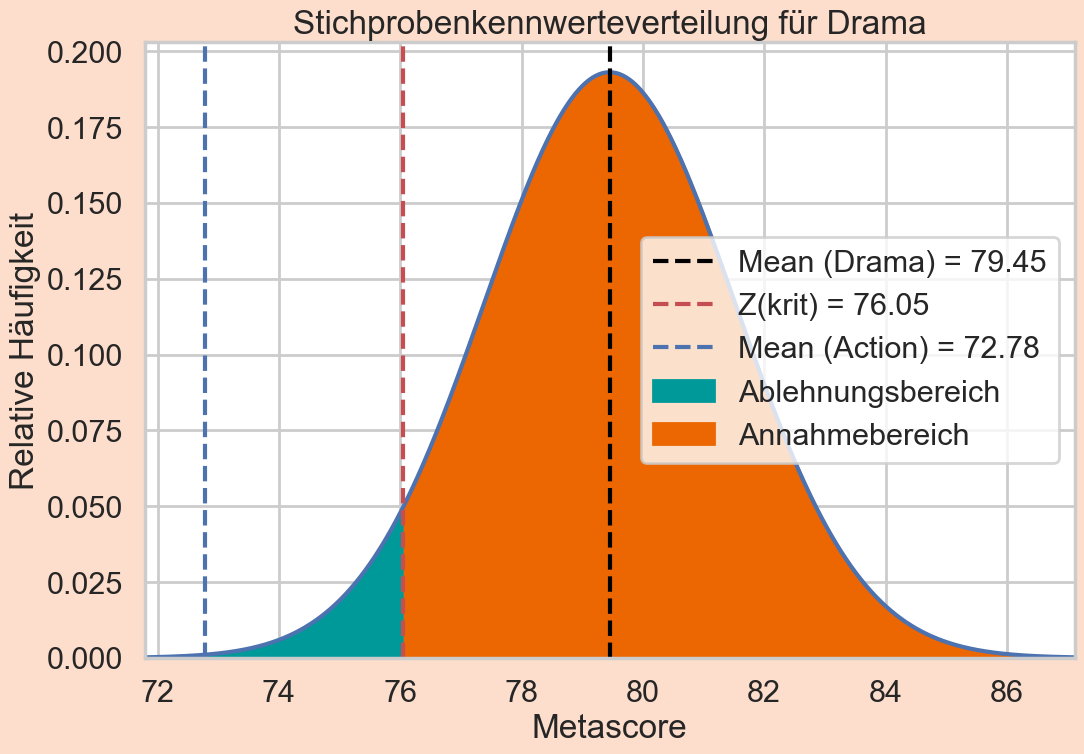

In [108]:
plt.figure(figsize=(12, 8), facecolor=healthy_orange_25)
plt.plot(x_werte, y_werte)
plt.axvline(x=mean_stichprobe_drama, 
            color='black', 
            label=f"Mean (Drama) = {mean_stichprobe_drama:.2f}", 
            linestyle='--')
plt.axvline(x=untere_grenze, 
            color='r', 
            label=f"Z(krit) = {untere_grenze:.2f}", 
            linestyle='--')
plt.axvline(x=mean_stichprobe_action, 
            label=f"Mean (Action) = {mean_stichprobe_action:.2f}", 
            linestyle='--')
plt.fill_between(x_werte, 
                 y_werte, 
                 where=x_werte < untere_grenze, 
                 color=siemens_petrol, 
                 label='Ablehnungsbereich')
plt.fill_between(x_werte, 
                 y_werte, 
                 where=x_werte > untere_grenze, 
                 color=healthy_orange, 
                 label='Annahmebereich')
plt.ylim(0, max(y_werte) + 0.01)
plt.title('Stichprobenkennwerteverteilung für Drama')
zus_unt = 1
plt.xlim(mean_stichprobe_action - zus_unt, mean_stichprobe_drama + mean_stichprobe_drama - mean_stichprobe_action + zus_unt)
plt.xlabel('Metascore')
plt.ylabel('Relative Häufigkeit')
plt.legend()
plt.show()